In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [7]:
# Завантаження вихідного набору даних
df = pd.read_csv('data.csv', parse_dates=['DT'])
print(f'[{df.shape[0]} рядків]')
df.rename(columns={'DT': 'Timestamp', 'Measurement': 'y'}, inplace=True)
# Буде використовуватися історія за 48 годин спостережень
look_back = 48
internal_units = 32 # Визначення кількості нейронів
batch_size = 8 # Розмір кучі
epochs = 200 # Кількість епох

[456 рядків]


In [8]:
# Формування даних
data = []

for i in range(len(df) - look_back):
    data.append(
        {
            'y': df.iloc[i + look_back, 1],
            'X': df.iloc[i:(i + look_back), 1].values
        })


df_ = pd.DataFrame(data)
print(df_)

        y                                                  X
0   6.451  [6.305967222222223, 5.355894722222223, 4.12272...
1   5.563  [5.355894722222223, 4.122725905292479, 3.54673...
2   4.319  [4.122725905292479, 3.5467375, 3.2406116666666...
3   3.608  [3.5467375, 3.2406116666666667, 3.535148746518...
4   3.309  [3.2406116666666667, 3.535148746518106, 4.2825...
..    ...                                                ...
403 6.738  [6.914265, 6.901684166666667, 6.74934166666666...
404 6.578  [6.901684166666667, 6.749341666666667, 6.24508...
405 6.592  [6.749341666666667, 6.245081666666667, 5.71907...
406 6.786  [6.245081666666667, 5.719071666666666, 6.32710...
407 6.396  [5.719071666666666, 6.327109166666667, 5.61673...

[408 rows x 2 columns]


In [9]:
# Задаєм імена колонкам
col_names = []
for i in reversed(range(look_back)):
    col_names.append(f'L{i + 1}')
print(col_names)

y = pd.DataFrame(df_['y'].to_list(), columns=['y'])
X = pd.DataFrame(df_['X'].to_list(), columns=col_names)
print(y)
print(X)

['L48', 'L47', 'L46', 'L45', 'L44', 'L43', 'L42', 'L41', 'L40', 'L39', 'L38', 'L37', 'L36', 'L35', 'L34', 'L33', 'L32', 'L31', 'L30', 'L29', 'L28', 'L27', 'L26', 'L25', 'L24', 'L23', 'L22', 'L21', 'L20', 'L19', 'L18', 'L17', 'L16', 'L15', 'L14', 'L13', 'L12', 'L11', 'L10', 'L9', 'L8', 'L7', 'L6', 'L5', 'L4', 'L3', 'L2', 'L1']
        y
0   6.451
1   5.563
2   4.319
3   3.608
4   3.309
..    ...
403 6.738
404 6.578
405 6.592
406 6.786
407 6.396

[408 rows x 1 columns]
      L48   L47   L46   L45   L44   L43   L42   L41   L40   L39  ...   L10  \
0   6.306 5.356 4.123 3.547 3.241 3.535 4.283 6.261 7.506 8.461  ... 7.106   
1   5.356 4.123 3.547 3.241 3.535 4.283 6.261 7.506 8.461 7.698  ... 6.820   
2   4.123 3.547 3.241 3.535 4.283 6.261 7.506 8.461 7.698 7.502  ... 6.525   
3   3.547 3.241 3.535 4.283 6.261 7.506 8.461 7.698 7.502 7.554  ... 6.726   
4   3.241 3.535 4.283 6.261 7.506 8.461 7.698 7.502 7.554 7.242  ... 6.938   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   

In [10]:
# MinMaxScaller - задаєм для всього датасету
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
# Масштабуєм дані
X = scalerX.fit_transform(X)
y = scalerY.fit_transform(y)

In [11]:
# Формуємо фрейм даних з часовими мітками
T = df['Timestamp'][look_back:]
T.reset_index(drop=True, inplace=True)
print(T)

0     2022-12-14 00:00:00
1     2022-12-14 01:00:00
2     2022-12-14 02:00:00
3     2022-12-14 03:00:00
4     2022-12-14 04:00:00
              ...        
403   2022-12-30 19:00:00
404   2022-12-30 20:00:00
405   2022-12-30 21:00:00
406   2022-12-30 22:00:00
407   2022-12-30 23:00:00
Name: Timestamp, Length: 408, dtype: datetime64[ns]


In [12]:
# Об'єднаний набір даних
dataset = pd.concat([T, pd.DataFrame(y, columns=['y']), pd.DataFrame(X, columns=col_names)], axis=1)
dataset
print(dataset)

              Timestamp     y   L48   L47   L46   L45   L44   L43   L42   L41  \
0   2022-12-14 00:00:00 0.624 0.602 0.456 0.267 0.178 0.131 0.177 0.291 0.595   
1   2022-12-14 01:00:00 0.488 0.456 0.267 0.178 0.131 0.177 0.291 0.595 0.786   
2   2022-12-14 02:00:00 0.297 0.267 0.178 0.131 0.177 0.291 0.595 0.786 0.932   
3   2022-12-14 03:00:00 0.188 0.178 0.131 0.177 0.291 0.595 0.786 0.932 0.815   
4   2022-12-14 04:00:00 0.142 0.131 0.177 0.291 0.595 0.786 0.932 0.815 0.785   
..                  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
403 2022-12-30 19:00:00 0.668 0.695 0.693 0.670 0.592 0.512 0.605 0.496 0.296   
404 2022-12-30 20:00:00 0.643 0.693 0.670 0.592 0.512 0.605 0.496 0.296 0.234   
405 2022-12-30 21:00:00 0.646 0.670 0.592 0.512 0.605 0.496 0.296 0.234 0.179   
406 2022-12-30 22:00:00 0.675 0.592 0.512 0.605 0.496 0.296 0.234 0.179 0.171   
407 2022-12-30 23:00:00 0.616 0.512 0.605 0.496 0.296 0.234 0.179 0.171 0.225   

     ...   L10    L9    L8 

In [13]:
import datetime as dt

# Часові мітки для поділу на навчальний та тестовий набори
start_date_train = dt.datetime(2022, 12, 12)
end_date_train = dt.datetime(2022, 12, 29)
start_date_test = dt.datetime(2022, 12, 29)
end_date_test = dt.datetime(2022, 12, 31)

# Поділ набору даних
train = dataset[dataset['Timestamp'] < start_date_test]
test = dataset[dataset['Timestamp'] >= start_date_test]

In [14]:
print(train)
print(f'[{train.shape[0]} rows]')

              Timestamp     y   L48   L47   L46   L45   L44   L43   L42   L41  \
0   2022-12-14 00:00:00 0.624 0.602 0.456 0.267 0.178 0.131 0.177 0.291 0.595   
1   2022-12-14 01:00:00 0.488 0.456 0.267 0.178 0.131 0.177 0.291 0.595 0.786   
2   2022-12-14 02:00:00 0.297 0.267 0.178 0.131 0.177 0.291 0.595 0.786 0.932   
3   2022-12-14 03:00:00 0.188 0.178 0.131 0.177 0.291 0.595 0.786 0.932 0.815   
4   2022-12-14 04:00:00 0.142 0.131 0.177 0.291 0.595 0.786 0.932 0.815 0.785   
..                  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
355 2022-12-28 19:00:00 0.695 0.648 0.635 0.642 0.566 0.490 0.505 0.379 0.284   
356 2022-12-28 20:00:00 0.693 0.635 0.642 0.566 0.490 0.505 0.379 0.284 0.182   
357 2022-12-28 21:00:00 0.670 0.642 0.566 0.490 0.505 0.379 0.284 0.182 0.134   
358 2022-12-28 22:00:00 0.592 0.566 0.490 0.505 0.379 0.284 0.182 0.134 0.171   
359 2022-12-28 23:00:00 0.512 0.490 0.505 0.379 0.284 0.182 0.134 0.171 0.128   

     ...   L10    L9    L8 

In [15]:
# Скидання індексу
test.reset_index(drop=True, inplace=True)
print(test)
print(f'[{test.shape[0]} rows]')

             Timestamp     y   L48   L47   L46   L45   L44   L43   L42   L41  \
0  2022-12-29 00:00:00 0.605 0.505 0.379 0.284 0.182 0.134 0.171 0.128 0.344   
1  2022-12-29 01:00:00 0.496 0.379 0.284 0.182 0.134 0.171 0.128 0.344 0.377   
2  2022-12-29 02:00:00 0.296 0.284 0.182 0.134 0.171 0.128 0.344 0.377 0.593   
3  2022-12-29 03:00:00 0.234 0.182 0.134 0.171 0.128 0.344 0.377 0.593 0.757   
4  2022-12-29 04:00:00 0.179 0.134 0.171 0.128 0.344 0.377 0.593 0.757 0.806   
5  2022-12-29 05:00:00 0.171 0.171 0.128 0.344 0.377 0.593 0.757 0.806 0.810   
6  2022-12-29 06:00:00 0.225 0.128 0.344 0.377 0.593 0.757 0.806 0.810 0.809   
7  2022-12-29 07:00:00 0.331 0.344 0.377 0.593 0.757 0.806 0.810 0.809 0.778   
8  2022-12-29 08:00:00 0.372 0.377 0.593 0.757 0.806 0.810 0.809 0.778 0.714   
9  2022-12-29 09:00:00 0.570 0.593 0.757 0.806 0.810 0.809 0.778 0.714 0.655   
10 2022-12-29 10:00:00 0.716 0.757 0.806 0.810 0.809 0.778 0.714 0.655 0.655   
11 2022-12-29 11:00:00 0.783 0.806 0.810

In [16]:
# Вибір масивів для навчання та тестування
X_train = train.iloc[:, 2:]
y_train = train.iloc[:, 1:2]
X_test = test.iloc[:, 2:]
y_test = test.iloc[:, 1:2]

In [17]:
# Створення та навчання моделі LSTM
model = Sequential()
model.add(LSTM(internal_units, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/200
45/45 [==============================] - 3s 14ms/step - loss: 0.1162
Epoch 2/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0537
Epoch 3/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0440
Epoch 4/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0308
Epoch 5/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0198
Epoch 6/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0168
Epoch 7/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0152
Epoch 8/200
45/45 [==============================] - 1s 17ms/step - loss: 0.0142
Epoch 9/200
45/45 [==============================] - 1s 19ms/step - loss: 0.0117
Epoch 10/200
45/45 [==============================] - 1s 21ms/step - loss: 0.0101
Epoch 11/200
45/45 [==============================] - 1s 22ms/step - loss: 0.0087
Epoch 12/200
45/45 [==============================] - 1s 16ms/step - loss: 0.0078
Epoch 13/200
45/45 [=====

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Побудова прогнозу на основі тестових даних

In [19]:
y_pred = model.predict(X_test)
print(y_pred)

2/2 [==============================] - 1s 10ms/step
[[0.5061181 ]
 [0.5216594 ]
 [0.3491251 ]
 [0.19065927]
 [0.1600274 ]
 [0.14910513]
 [0.19105124]
 [0.31364006]
 [0.49927938]
 [0.5604596 ]
 [0.6792724 ]
 [0.75474393]
 [0.78240204]
 [0.7849059 ]
 [0.73762333]
 [0.7107826 ]
 [0.67752814]
 [0.64141464]
 [0.64014125]
 [0.66976553]
 [0.680889  ]
 [0.66424024]
 [0.61670405]
 [0.6032516 ]
 [0.5832388 ]
 [0.5071106 ]
 [0.3193109 ]
 [0.19922851]
 [0.14344928]
 [0.1344807 ]
 [0.16940261]
 [0.31433773]
 [0.5014173 ]
 [0.57595986]
 [0.6696944 ]
 [0.76303786]
 [0.81390494]
 [0.81154937]
 [0.7888521 ]
 [0.7504224 ]
 [0.725322  ]
 [0.67159534]
 [0.66931605]
 [0.6794708 ]
 [0.6757204 ]
 [0.63620496]
 [0.59842384]
 [0.5709432 ]]


In [20]:
import matplotlib.pyplot as plt

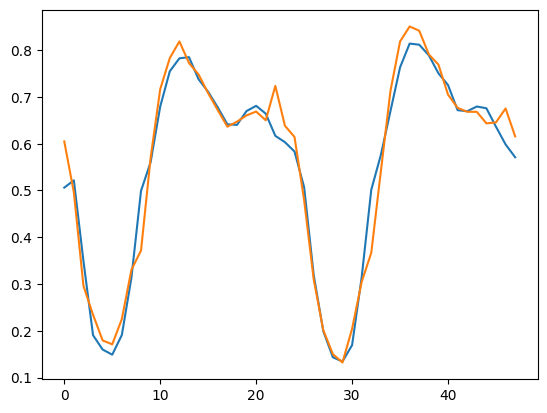

In [21]:
plt.plot(y_pred)
plt.plot(y_test)

In [22]:
# Зворотнє масштабування
y_pred_ = scalerY.inverse_transform(y_pred)
y_test_ = scalerY.inverse_transform(y_test)

In [23]:
# Функція оцінки точності
def performance_evaluation(y_true: pd.DataFrame,
                           y_pred: pd.DataFrame,
                           method_name: str,
                           save_to_file: bool = True):

    r2_value = r2(y_true, y_pred)
    mse_value = mse(y_true, y_pred)
    rmse_value = mse(y_true, y_pred, squared=False)
    mae_value = mae(y_true, y_pred)
    mape_value = mape(y_true, y_pred)

    print(f'\nPerformance Evaluation for {method_name}')
    print(f'R2: {r2_value:3.2f}')
    print(f'MSE: {mse_value:3.2f}')
    print(f'RMSE: {rmse_value:3.2f}')
    print(f'MAE: {mae_value:3.2f}')
    print(f'MAPE: {mape_value:3.2f}%')

    if save_to_file:
        report_file = os.path.realpath(os.path.join(dir_name, '..', 'data', 'forecasting-report.txt'))
        f = open(report_file, 'a')

        print(f'#################### {datetime.now().strftime("%d/%m/%Y %H:%M:%S")} ####################', file=f)
        print(f'Performance Evaluation for {method_name.upper()} method\n', file=f)

        table = [['METRIC', 'VALUE'],
                 ['R2', f'{r2_value:3.2f}'],
                 ['MSE', f'{mse_value:3.2f}'],
                 ['RMSE', f'{rmse_value:3.2f}'],
                 ['MAE', f'{mae_value:3.2f}'],
                 ['MAPE', f'{mape_value:3.2f}%']]
        print(tabulate(table, headers='firstrow', tablefmt='github'), file=f)
        print('\n', file=f)

        f.close()


Performance Evaluation for LTSM (based on test data)
R2: 0.96
MSE: 0.08
RMSE: 0.28
MAE: 0.20
MAPE: 0.03%


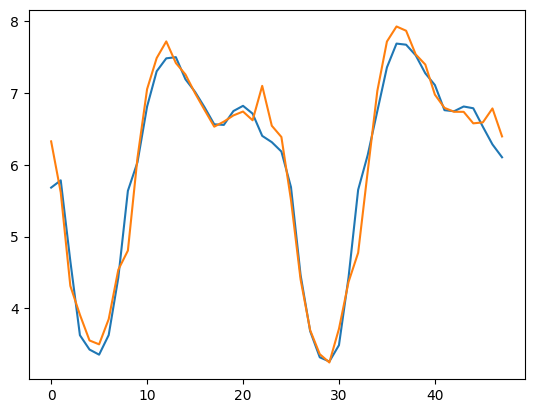

In [24]:
plt.plot(y_pred_)
plt.plot(y_test_)
# Оцінка точності
performance_evaluation(y_test_, y_pred_, 'LTSM (based on test data)', False)

In [25]:
X_train

,L48,L47,L46,L45,L44,L43,L42,L41,L40,L39,...,L10,L9,L8,L7,L6,L5,L4,L3,L2,L1
0,0.602,0.456,0.267,0.178,0.131,0.177,0.291,0.595,0.786,0.932,...,0.724,0.681,0.635,0.666,0.699,0.759,0.812,0.821,0.733,0.604
1,0.456,0.267,0.178,0.131,0.177,0.291,0.595,0.786,0.932,0.815,...,0.681,0.635,0.666,0.699,0.759,0.812,0.821,0.733,0.604,0.624
2,0.267,0.178,0.131,0.177,0.291,0.595,0.786,0.932,0.815,0.785,...,0.635,0.666,0.699,0.759,0.812,0.821,0.733,0.604,0.624,0.488
3,0.178,0.131,0.177,0.291,0.595,0.786,0.932,0.815,0.785,0.793,...,0.666,0.699,0.759,0.812,0.821,0.733,0.604,0.624,0.488,0.297
4,0.131,0.177,0.291,0.595,0.786,0.932,0.815,0.785,0.793,0.745,...,0.699,0.759,0.812,0.821,0.733,0.604,0.624,0.488,0.297,0.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.648,0.635,0.642,0.566,0.490,0.505,0.379,0.284,0.182,0.134,...,0.606,0.739,0.808,0.802,0.780,0.757,0.685,0.656,0.639,0.675
356,0.635,0.642,0.566,0.490,0.505,0.379,0.284,0.182,0.134,0.171,...,0.739,0.808,0.802,0.780,0.757,0.685,0.656,0.639,0.675,0.695
357,0.642,0.566,0.490,0.505,0.379,0.284,0.182,0.134,0.171,0.128,...,0.808,0.802,0.780,0.757,0.685,0.656,0.639,0.675,0.695,0.693
358,0.566,0.490,0.505,0.379,0.284,0.182,0.134,0.171,0.128,0.344,...,0.802,0.780,0.757,0.685,0.656,0.639,0.675,0.695,0.693,0.670


### Побудова прогнозу за допомогою рекурентної схеми

In [26]:
X = X_train.iloc[-1:]
X = X.reset_index(drop=True)
print(X)
y_pred = model.predict(X)
print(y_pred)

    L48   L47   L46   L45   L44   L43   L42   L41   L40   L39  ...   L10  \
0 0.490 0.505 0.379 0.284 0.182 0.134 0.171 0.128 0.344 0.377  ... 0.780   

     L9    L8    L7    L6    L5    L4    L3    L2    L1  
0 0.757 0.685 0.656 0.639 0.675 0.695 0.693 0.670 0.592  

[1 rows x 48 columns]
1/1 [==============================] - 0s 27ms/step
[[0.55372953]]


In [27]:
# Формування вхідного набору даних на основі прогнозу
print(f'{X.to_string(index=False, header=True)} {y_pred.tolist()[0]}')
X_list = []
y_list = []
y_pred_new = []
for i in range(len(y_test)):
    X_list = X.iloc[:, 1:].values.tolist()
    y_list = y_pred.tolist()
    X = pd.DataFrame(X_list[0] + y_list[0])
    X = X.transpose()
    X.columns = col_names
    y_pred = model.predict(X, verbose=0)
    print(f'{X.to_string(index=False, header=False)} {y_pred.tolist()[0]}')
    y_pred_new.append(y_pred.tolist()[0])

  L48   L47   L46   L45   L44   L43   L42   L41   L40   L39   L38   L37   L36   L35   L34   L33   L32   L31   L30   L29   L28   L27   L26   L25   L24   L23   L22   L21   L20   L19   L18   L17   L16   L15   L14   L13   L12   L11   L10    L9    L8    L7    L6    L5    L4    L3    L2    L1
0.490 0.505 0.379 0.284 0.182 0.134 0.171 0.128 0.344 0.377 0.593 0.757 0.806 0.810 0.809 0.778 0.714 0.655 0.655 0.670 0.667 0.684 0.742 0.744 0.573 0.701 0.591 0.358 0.218 0.152 0.153 0.208 0.323 0.382 0.606 0.739 0.808 0.802 0.780 0.757 0.685 0.656 0.639 0.675 0.695 0.693 0.670 0.592 [0.5537295341491699]
0.505 0.379 0.284 0.182 0.134 0.171 0.128 0.344 0.377 0.593 0.757 0.806 0.810 0.809 0.778 0.714 0.655 0.655 0.670 0.667 0.684 0.742 0.744 0.573 0.701 0.591 0.358 0.218 0.152 0.153 0.208 0.323 0.382 0.606 0.739 0.808 0.802 0.780 0.757 0.685 0.656 0.639 0.675 0.695 0.693 0.670 0.592 0.554 [0.5251532793045044]
0.379 0.284 0.182 0.134 0.171 0.128 0.344 0.377 0.593 0.757 0.806 0.810 0.809 0.778 0.714 0.65

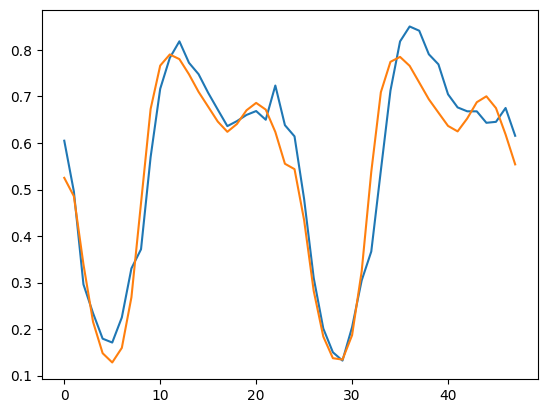

In [28]:
plt.plot(y_test)
plt.plot(y_pred_new)

In [29]:
# Масштабування даних
y_pred_new_ = scalerY.inverse_transform(y_pred_new)
y_test_ = scalerY.inverse_transform(y_test)

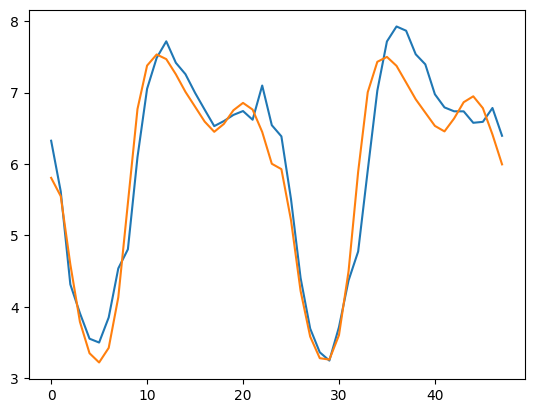

In [30]:
plt.plot(y_test_)
plt.plot(y_pred_new_)

In [31]:
# Оцінка точності
performance_evaluation(y_test_, y_pred_new_, 'LTSM (based on recurrent scheme)', False)


Performance Evaluation for LTSM (based on recurrent scheme)
R2: 0.91
MSE: 0.17
RMSE: 0.42
MAE: 0.33
MAPE: 0.06%
